<a href="https://colab.research.google.com/github/mtjon/infompr-group-project/blob/feature%2Frnn/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title Generation through Abstract Summarisation with RNNs



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text==2.9.* tensorflow==2.9.*
!pip install einops

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text
import tensorflow_text as tf_text

In [ ]:
import requests

In [ ]:
import random
from random import shuffle
# Seed voor herhaalbaarheid
random.seed(42)

TRAIN_PCT = 70
TEST_PCT = 25
VAL_PCT = 5

TOTAL_PCT = TRAIN_PCT + TEST_PCT + VAL_PCT

# modified data externally to remove all blank lines
def write_data(f, ext, mod):
    # Code van https://github.com/EagleW/Writing-editing-Network/blob/master/split_data.py
    file1=open(f, 'r')
    lines=file1.readlines()
    file1.close()
    abs_t = []
    abstracts = []
    titles = []
    i = 0
    # TODO: possibly generates wrong tibs/abs when encounter
    for line in lines:
        if i % mod == 0:
            titles.append(line)
        elif i % mod == 1:
            abstracts.append(line)
        i += 1
    for i in range(len(abstracts)):
        if len(titles[i]) > 0 and len(abstracts[i]) > 0:
            h_a_pair = (titles[i], abstracts[i])
            abs_t.append(h_a_pair)

    GRANULARITY_FACTOR = 100

    shuffle(abs_t)
    total_lines = len(abs_t)
    train_lines = (((total_lines * GRANULARITY_FACTOR) // TOTAL_PCT) * TRAIN_PCT) // GRANULARITY_FACTOR
    test_lines = (((total_lines * GRANULARITY_FACTOR) // TOTAL_PCT) * TEST_PCT) // GRANULARITY_FACTOR
    val_lines = total_lines - (train_lines + test_lines) # different calculation to ensure no lines get left out

    i = 0
    with open("val{}.txt".format(ext), 'w') as file1:
      for i in range(train_lines):
          file1.writelines(abs_t[i][0])
          file1.writelines(abs_t[i][1])
      #    file1.writelines("\n")

    with open("test{}.txt".format(ext), 'w') as file1:
      for i in range(train_lines, train_lines+test_lines):
          file1.writelines(abs_t[i][0])
          file1.writelines(abs_t[i][1])
      #    file1.writelines("\n")

    with open("train{}.txt".format(ext), 'w') as file1:
      for i in range(train_lines+test_lines, total_lines):
          file1.writelines(abs_t[i][0])
          file1.writelines(abs_t[i][1])
      #    file1.writelines("\n")

    print("Split data into (train, test, validate) as follows: ", (train_lines, test_lines, val_lines), "from total lines:", total_lines)


def get_abs_and_titles_from_raw(path_to_file):
    abstracts, titles = [], []
    with open(path_to_file) as data:
        lines = data.readlines()
        for abs in lines[1::2]:
            abstracts.append(abs.strip())
        for title in lines[0::2]:
            # // TODO: check if we need to add start and end tokens
            titles.append(title.strip())
            # titles.append('[START] ' + title.strip() + ' [END]')
    return abstracts, titles


In [ ]:
# Necessary when upload fails (Firefox+Colab issue)

# from google.colab import files
# uploaded = files.upload()

In [ ]:
write_data("acl_titles_and_abstracts_mod.txt", "", 2) # writes train, val, test.txt

train_text, train_labels = get_abs_and_titles_from_raw('train.txt')
val_text, val_labels = get_abs_and_titles_from_raw('val.txt')

train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_labels)).batch(16)

Split data into (train, test, validate) as follows:  (7612, 2718, 545) from total lines: 10875


In [ ]:
for abs, tit in train_dataset.take(1):
    print('> Abstract examples:')
    for i, a in enumerate(abs.numpy()):
        print(i+1, a.decode('utf-8'))
        
    print()
    
    print('> Title examples:')
    for i, t in enumerate(tit.numpy()):
        print(i+1, t.decode('utf-8'))


> Abstract examples:
1 the computation of meaning similarity as operationalized by vector-based models has found widespread use in many tasks ranging from the acquisition of synonyms and paraphrases to word sense disambiguation and textual entailment . vector-based models are typically directed at representing words in isolation and thus best suited for measuring similarity out of context . in his paper we propose a probabilistic framework for measuring similarity in context . central to our approach is the intuition that word meaning is represented as a probability distribution over a set of latent senses and is modulated by context . experimental results on lexical substitution and word similarity show that our algorithm outperforms previously proposed models .
2 this paper ties up some loose ends in finite-state optimality theory . first , it discusses how to perform comprehension under optimality theory grammars consisting of finite-state constraints . comprehension has not been mu

In [ ]:
def title_preprocessor(text):
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

def abstract_preprocessor(text):
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    return text

abs_text_processor = tf.keras.layers.TextVectorization(
    standardize=abstract_preprocessor,
    ragged=True,
    output_mode='int'
    )

tit_text_processor = tf.keras.layers.TextVectorization(
    standardize=title_preprocessor,
    ragged=True,
    output_mode='int'
    )

abs_text_processor.adapt(train_dataset.map(lambda abs, tit: abs))
tit_text_processor.adapt(train_dataset.map(lambda abs, tit: tit))



def process_text(context, target):
    context = abs_text_processor(context).to_tensor()
    target = tit_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_dataset.map(process_text, tf.data.AUTOTUNE)
val_ds = val_dataset.map(process_text, tf.data.AUTOTUNE)



In [ ]:
import einops

#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

UNITS = 256

for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

# Encode the input sequence.
encoder = Encoder(abs_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')


[   2 1856    5  349  116   19 4431   20 2499   53]

[  2 216 130  40   8 104   0   0   0   0]
[216 130  40   8 104   3   0   0   0   0]
Context tokens, shape (batch, s): (16, 223)
Encoder output, shape (batch, s, units): (16, 223, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(tit_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (16, 223, 256)
Target sequence, shape (batch, t, units): (16, 16, 256)
Attention result, shape (batch, t, units): (16, 16, 256)
Attention weights, shape (batch, t, s):    (16, 16, 223)


In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)


@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

decoder = Decoder(tit_text_processor, UNITS)
logits = decoder(ex_context, ex_tar_in)

In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]


@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result


@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state



In [ ]:
# Generation loop

# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()



array([b'c-rater tabular interpretable transitivity out portability vocabulary open bag-of-opinions self-training',
       b'mathias soufian metadata modernizing topic-based adaptive & ambiguities slovene (',
       b'la assignment variation terms verification kurosawa clarification peng tor method'],
      dtype=object)

In [ ]:
class SummarisationModel(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits



In [ ]:
model = SummarisationModel(UNITS, abs_text_processor, tit_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')


Context tokens, shape: (batch, s, units) (16, 223)
Target tokens, shape: (batch, t) (16, 16)
logits, shape: (batch, t, target_vocabulary_size) (16, 16, 1807)


In [ ]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss
def masked_acc(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    mask = label != 0
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)
model.compile(
    loss=masked_loss,
    optimizer='adam',
    metrics=[masked_acc])

In [ ]:
# Model configuration
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * tit_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 7.4994235, 'expected_acc': 0.0005534034311012728}

In [ ]:
# model.evaluate(val_ds, steps=20, return_dict=True)

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=25,
    steps_per_epoch = 100,
    validation_data=val_ds,
    # callbacks=[ tf.keras.callbacks.EarlyStopping(patience=3) ]
    )

Epoch 1/25
100/100 [==============================] - 29s 165ms/step - loss: 5.7102 - masked_acc: 0.1545 - masked_loss: 5.7008 - val_loss: 6.2495 - val_masked_acc: 0.1563 - val_masked_loss: 6.2496
Epoch 2/25
100/100 [==============================] - 15s 147ms/step - loss: 3.3378 - masked_acc: 0.4212 - masked_loss: 3.2923 - val_loss: 6.5437 - val_masked_acc: 0.1512 - val_masked_loss: 6.5436
Epoch 3/25
100/100 [==============================] - 13s 133ms/step - loss: 1.6526 - masked_acc: 0.7124 - masked_loss: 1.6144 - val_loss: 6.9989 - val_masked_acc: 0.1383 - val_masked_loss: 6.9988
Epoch 4/25
100/100 [==============================] - 11s 107ms/step - loss: 0.8980 - masked_acc: 0.8464 - masked_loss: 0.8852 - val_loss: 7.4950 - val_masked_acc: 0.1245 - val_masked_loss: 7.4947
Epoch 5/25
100/100 [==============================] - 11s 106ms/step - loss: 0.6124 - masked_acc: 0.8809 - masked_loss: 0.6025 - val_loss: 8.1069 - val_masked_acc: 0.1327 - val_masked_loss: 8.1068
Epoch 6/25
100/

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 1s 24ms/step - loss: 10.1910 - masked_acc: 0.1272 - masked_loss: 10.1910


{'loss': 10.190996170043945,
 'masked_acc': 0.1272369772195816,
 'masked_loss': 10.190996170043945}

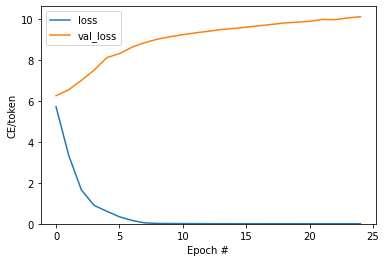

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()